In [1]:
%matplotlib inline

from tdt import read_block
import numpy as np
from numpy import savetxt
from numpy import stack
import matplotlib.pyplot as plt
import os
import statistics
import scipy 
from scipy.io import savemat


In [2]:
def extract_name_streams(blocknames, tankdir, filenames, trimstart, trimend):
	for block in blocknames:
		full_path = os.path.join(tankdir, block)
		data = read_block(full_path)	

		print('Epoc Events List')
		print(data.epocs)
		print('Note event info')
		print(data.epocs.Note)
		print('Onset/ Offset Arrays')
		print(data.epocs.Note.onset)
		print(data.epocs.Note.offset)
  
		fields = list(data.streams.keys())
		files = filenames.get(block)
		chars = []
		GCAMP_list = []
		ISOS_list = []
		# identify signal names
		for field in fields:
			last_char = field[-1]
			if last_char not in chars and (last_char == "A" or last_char == "C" or last_char == "E" or last_char == "G"):
				if ("_470A" in fields):
					GCAMP = "_470A"
					ISOS = "_405A"
					GCAMP_list.append(GCAMP)
					ISOS_list.append(ISOS)
				else:
					chars.append(last_char)
					GCAMP = "_465" + last_char
					GCAMP_list.append(GCAMP)
					ISOS = "_405" + last_char
					ISOS_list.append(ISOS)
		process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
  
  
def process(GCAMP_list, ISOS_list, files, data, trimstart, trimend):
	for i in range (0, len(GCAMP_list)):
		file = files[i]
		
		# trim
		GCAMP = GCAMP_list[i]
		ISOS = ISOS_list[i]
		fs = data.streams[GCAMP.title()].fs
		start = trimstart
		stop = trimend
		time = np.arange(start=1, stop=len(data.streams[GCAMP.title()].data)+1, step=1)/data.streams[GCAMP.title()].fs

		data_GCAMP = np.array(data.streams[GCAMP.title()].data)
		data_ISOS = np.array(data.streams[ISOS.title()].data)
		Signal_GCAMP = data_GCAMP[start:-stop]
		Signal_ISOS = data_ISOS[start:-stop]
		trimtime = time[start:-stop]

		# downsample
		N = fs
		arr_GCAMP = (np.arange(start = 1, stop = len(Signal_GCAMP) - N + 1, step = N)).astype(int)
		down_GCAMP = [statistics.mean(Signal_GCAMP[i:round(i+N-1)]) for i in arr_GCAMP]
		arr_ISOS = (np.arange(start=1, stop=len(Signal_ISOS) - N + 1, step=N)).astype(int)
		down_ISOS = [statistics.mean(Signal_ISOS[i:round(i + N - 1)]) for i in arr_ISOS]
		downtime = trimtime[::round(N)]
		downt = downtime[:len(down_GCAMP)]

		# smooth
		smooth_win = 2
		smooth_GCAMP = moving_average(down_GCAMP, smooth_win)
		smooth_ISOS = moving_average(down_ISOS, smooth_win)
		
  		# fit and calculate dff smoothed
		fit_data = np.polyfit(smooth_ISOS, smooth_GCAMP, 1)
		fit_ISOS = np.multiply(fit_data[0], smooth_ISOS) + fit_data[1]
		dF = smooth_GCAMP-fit_ISOS
		dFF = np.array(100*dF/fit_ISOS)

		# fit and calculate raw dff (this will throw polyfit errors)
		fit_data_raw = np.polyfit(data_ISOS, data_GCAMP, 1)
		fit_ISOS_raw = np.multiply(fit_data_raw[0], data_ISOS) + fit_data_raw[1]
		dF_raw = data_GCAMP-fit_ISOS_raw
		dFF_raw = np.array(100*dF_raw/fit_ISOS_raw)
	
  		# export data to .csv files
		z = stack((time, data_GCAMP, data_ISOS, dFF_raw), axis=-1)
		np.savetxt('raw ' + str(file) + '.csv', z, header='time,rawGCAMP,rawISOS,rawfit_ISOS,rawdFF,', delimiter= ',')
		
		w = stack((downt, smooth_GCAMP, smooth_ISOS, dFF), axis=-1)
		np.savetxt('smooth ' + str(file) + '.csv', w, header='time,smoothGCAMP,smoothISOS,smoothdFF', delimiter= ',')
  		
    	# export data to .mat file (already downsampled)
		scipy.io.savemat('dFF' + str(file) + '.mat', {'data1':dFF_raw,'Dts': time},oned_as='column')
  
  		# plot
		fig = plt.figure(figsize=(6,8))
		ax = fig.add_subplot(411)
		p1, = ax.plot(time, data.streams[GCAMP.title()].data, linewidth=2,
					  color='green', label='GCaMP')
		p2, = ax.plot(time, data.streams[ISOS.title()].data, linewidth=2,
					  color='blueviolet', label='Isosbestic')
		ax.set_xlabel('Time (s)')
		ax.set_ylabel('mV')
		ax.set_title('Raw Signals ' + str(file))
		ax.legend(handles=[p1, p2], loc='upper right')
		ax.set_xlim([start, time[len(time)-1]-stop])

		ax2 = fig.add_subplot(412)
		p3, = ax2.plot(downt, smooth_GCAMP, linewidth=2, color='green', label='Processed GCaMP')
		p4, = ax2.plot(downt, smooth_ISOS, linewidth=2, color='blueviolet', label='Processed Isosbestic')
		p5, = ax2.plot(downt, fit_ISOS, linewidth=2, color='dodgerblue', label='Fit Isosbestic')
		ax2.set_xlabel('Time (s)')
		ax2.set_ylabel('mV')
		ax2.set_title('Smoothed, Fit, and Aligned Signals ' + str(file))
		ax2.legend(handles=[p3, p4, p5], loc='upper right')
		ax2.set_xlim([start, len(downt)-stop])

		ax3 = fig.add_subplot(413)
		p6, = ax3.plot(downt, dF, linewidth=2, color='black', label='Baseline Corrected GCaMP')
		ax3.set_xlabel('Time (s)')
		ax3.set_ylabel(r'$\Delta$mV')
		ax3.set_title('Subtracted Signal ' + str(file))
		ax3.legend(handles=[p6], loc='upper right')
		ax3.set_xlim([start, len(downt)-stop])

		ax4 = fig.add_subplot(414)
		ax4.plot(downt, dFF, linewidth=2, color='green')
		ax4.set_xlabel('Time (s)')
		ax4.set_ylabel(r'$\Delta$F/F (%)')
		ax4.set_title(r'$\Delta$F/F, ' + str(file))
		ax4.set_xlim([start, len(downt)-stop])
		ax4.set_ylim([-20, 20])

		fig.suptitle('Data Processing ' + str(file), fontsize=16)
		fig.tight_layout()
		plt.savefig(str(file) + '.png')

		# plot just dff
		fig2 = plt.figure()
		ax = fig2.add_subplot(211)
		ax.plot(downt, dFF, linewidth=2, color='green')
		ax.set_xlabel('Time (s)')
		ax.set_ylabel(r'$\Delta$F/F (%)')
		ax.set_title(r'$\Delta$F/F, ' + str(file))
		ax.set_xlim([start, len(downt)-stop])
		ax.set_ylim([-20, 20])

		fig2.tight_layout()
		plt.savefig('dFF_' + str(file) + '.png')

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

Found Synapse note file: /Volumes/deem_lab/agrp_dio_fp/agrp_diofp_chow_thermal_d3/AgRP_DIOFP_29-210927-102843/Notes.txt
read from t=0s to t=5455.63s
Epoc Events List
Tick	[struct]
Note	[struct]
Note event info
name:	'Note'
onset:	array([  72., 5050.])
offset:	array([5050.,   inf])
type:	'onset'
type_str:	'epocs'
data:	array([1, 2])
dform:	4
size:	10
notes:	array(['AT 30C', 'Food Pellet'], dtype='<U11')
Onset/ Offset Arrays
[  72. 5050.]
[5050.   inf]


/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)


Found Synapse note file: /Volumes/deem_lab/agrp_dio_fp/agrp_diofp_chow_thermal_d3/AgRP_DIOFP_10x1-210927-121225/Notes.txt
read from t=0s to t=5503.87s
Epoc Events List
Tick	[struct]
Note	[struct]
Note event info
name:	'Note'
onset:	array([  63., 5037.])
offset:	array([5037.,   inf])
type:	'onset'
type_str:	'epocs'
data:	array([1, 2])
dform:	4
size:	10
notes:	array(['AT 30C', 'Food Pellet'], dtype='<U11')
Onset/ Offset Arrays
[  63. 5037.]
[5037.   inf]


/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)


Found Synapse note file: /Volumes/deem_lab/agrp_dio_fp/agrp_diofp_chow_thermal_d3/AgRP_DIOFP1_1415-210927-135113/Notes.txt
read from t=0s to t=5369.31s
Epoc Events List
Tick	[struct]
Note	[struct]
Note event info
name:	'Note'
onset:	array([  65., 4927.])
offset:	array([4927.,   inf])
type:	'onset'
type_str:	'epocs'
data:	array([1, 2])
dform:	4
size:	10
notes:	array(['AT 30C', 'Food Pellet'], dtype='<U11')
Onset/ Offset Arrays
[  65. 4927.]
[4927.   inf]


/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)
/var/folders/ks/y49f9w8n6lx_4lskh04jyk300000gq/T/ipykernel_1533/2551054551.py:34: RankWarning: Polyfit may be poorly conditioned
  process(GCAMP_list, ISOS_list, files, data, trimstart, trimend)


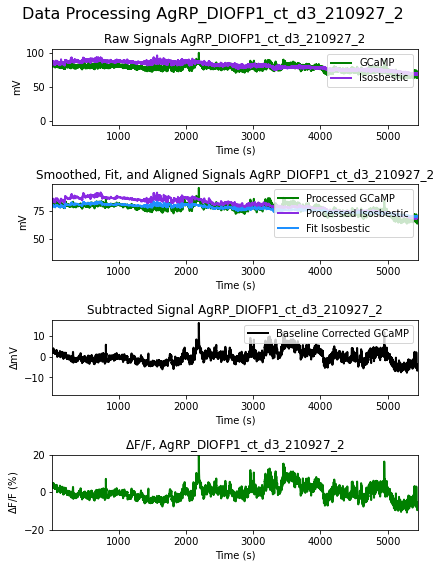

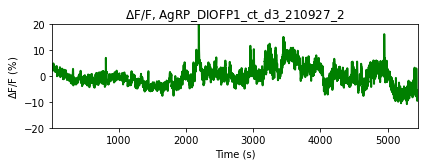

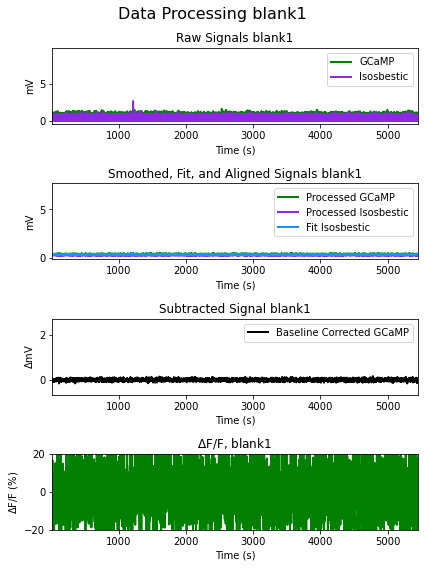

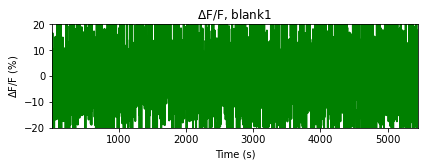

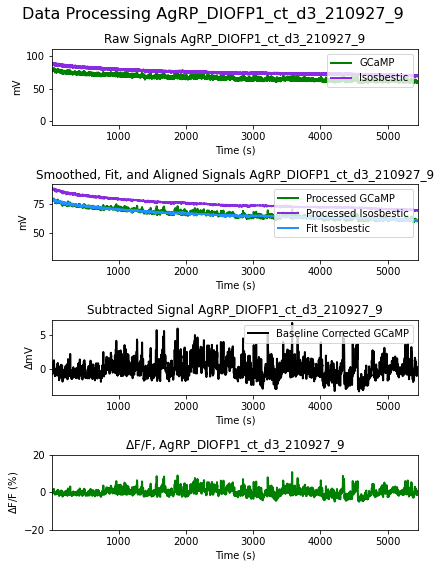

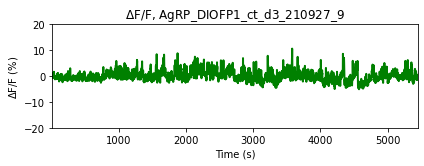

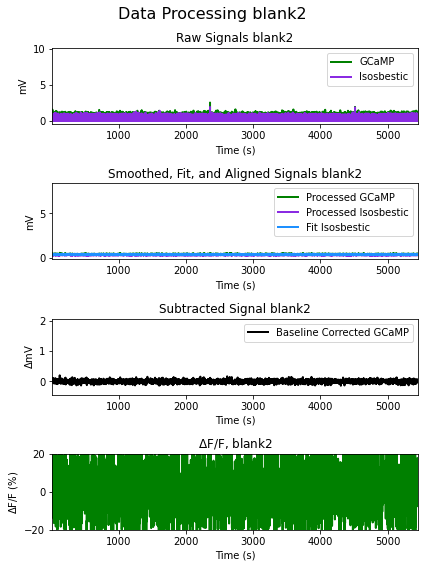

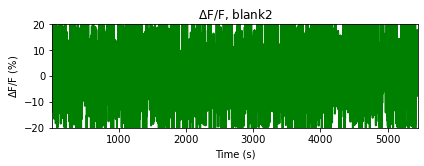

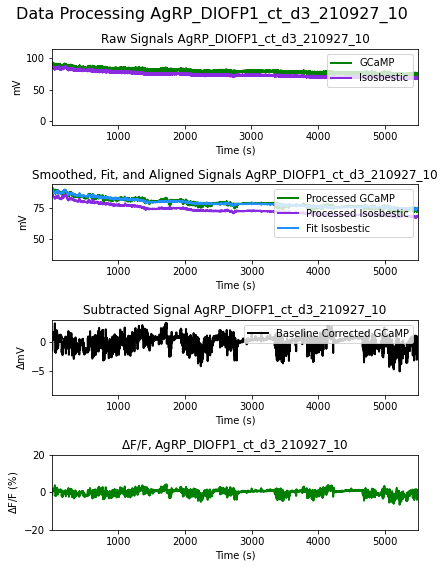

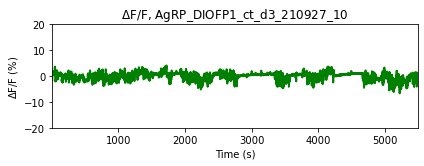

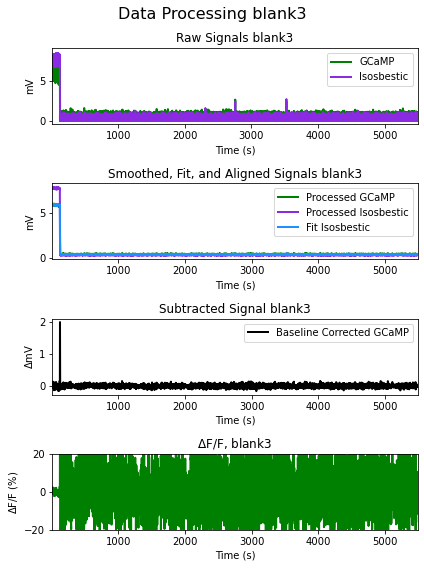

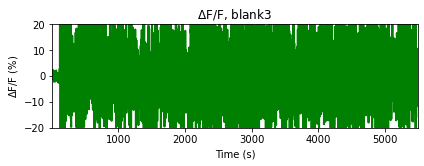

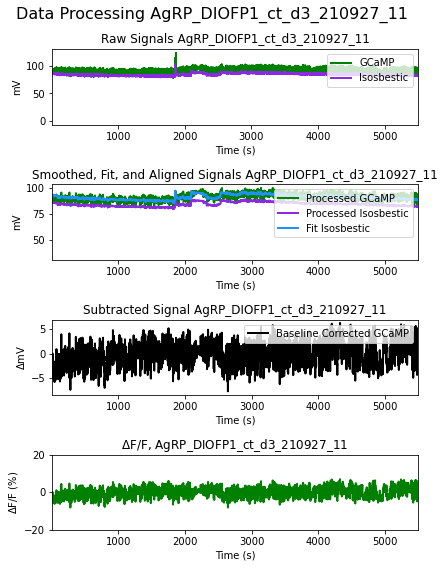

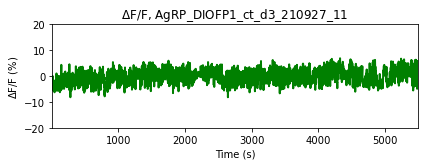

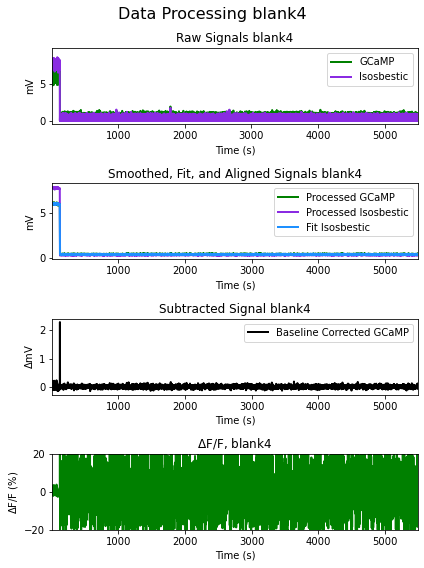

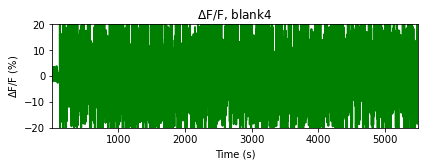

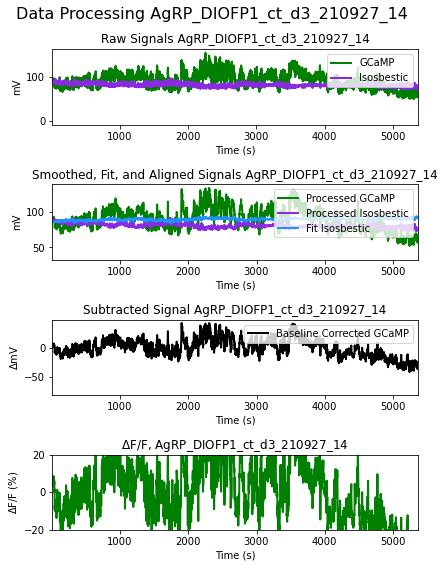

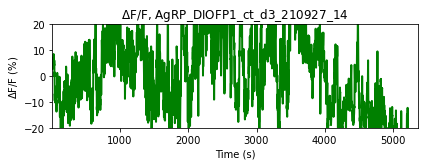

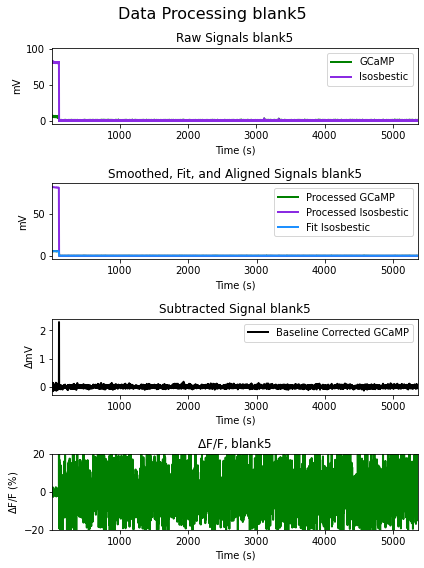

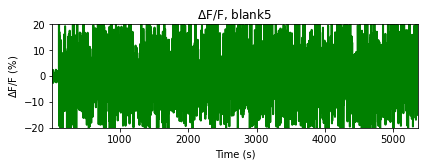

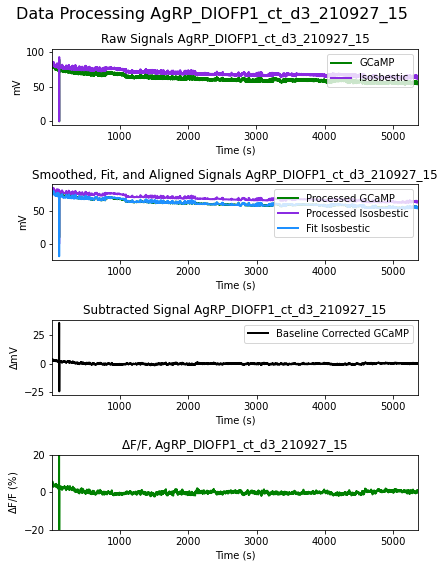

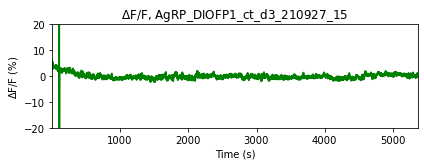

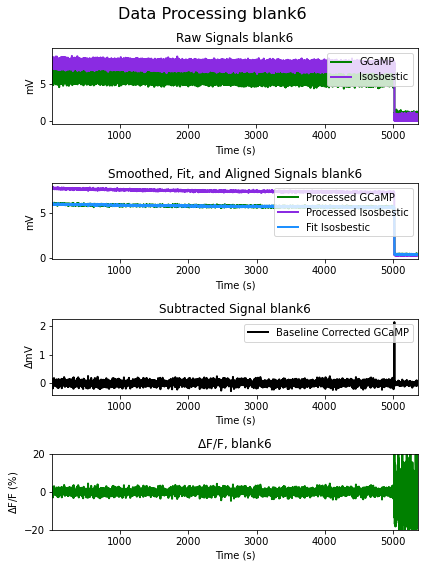

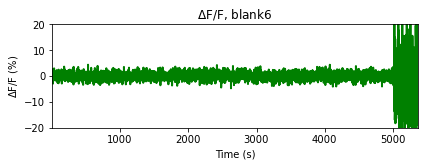

In [3]:
def main():
	tankdir = "/Volumes/deem_lab/agrp_dio_fp/agrp_diofp_chow_thermal_d3"
	n = 15
	savedata = "/Volumes/deem_lab/agrp_dio_fp/agrp_diofp_chow_thermal_d3/Data"
	savefigs = "/Volumes/deem_lab/agrp_dio_fp/agrp_diofp_chow_thermal_d3/Figures"
	
# cut a little off the front end
	trimstart = 10
	trimend = 10

#enter blockname (main folder)
	blocknames = [
				  'AgRP_DIOFP_29-210927-102843',
				  'AgRP_DIOFP_10x1-210927-121225',
				  'AgRP_DIOFP1_1415-210927-135113'
				  ]
	

#enter the file names you would like to attribute to the experiments to be output.
	filenames = {
		'AgRP_DIOFP_29-210927-102843': ['AgRP_DIOFP1_ct_d3_210927_2','blank1',
										'AgRP_DIOFP1_ct_d3_210927_9','blank2'],
		'AgRP_DIOFP_10x1-210927-121225': ['AgRP_DIOFP1_ct_d3_210927_10','blank3',
										'AgRP_DIOFP1_ct_d3_210927_11','blank4'],
		'AgRP_DIOFP1_1415-210927-135113': ['AgRP_DIOFP1_ct_d3_210927_14','blank5',
										'AgRP_DIOFP1_ct_d3_210927_15','blank6']
	
  }
	


	extract_name_streams(blocknames, tankdir, filenames, trimstart, trimend)


if __name__ == "__main__":
	main()

